In [47]:
import os
import sys
import pandas as pd
from tqdm import tqdm
from astropy.io import fits
import operator
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [28]:
%%bash

cd /home/jen55/urry2023/jen55/DRAGON_CNN && PYTHONPATH=$(pwd) ; export PYTHONPATH && pwd

/home/jen55/urry2023/jen55/DRAGON_CNN


In [14]:
os.chdir("/home/jen55/urry2023/jen55/DRAGON_CNN")
os.environ["PYTHONPATH"] = os.getcwd()

In [ ]:
%%bash

python modules/inference.py \
--model_path='models/merger_hsc_test-balanced-dev2-mtibrihw.pt' \
--model_type='dragon' \
--output_path='data_preprocessing/merger_training' \
--data_dir='data_preprocessing/merger_training' \
--slug='balanced-dev2' \
--n_workers=4 \
--parallel \
--batch_size=16 \
--label_col='classes' \
--n_classes=3 \
--normalize \
--dropout_rate=0.0004 \
--cutout_size=250 \
--channels=1

In [29]:
df = pd.read_csv(os.path.join(os.getcwd(), "data_preprocessing/training_run_merger_single_dual.csv"))

In [30]:
def cropND(img, bounding):
    start = tuple(map(lambda a, da: a//2-da//2, img.shape, bounding))
    end = tuple(map(operator.add, start, bounding))
    slices = tuple(map(slice, start, end))
    return img[slices]

In [77]:
# Load fits images based on dataframe
label_keys = pd.read_csv("data_preprocessing/training_datasets/labels.csv")
label_dict = label_keys.set_index('key')['value'].to_dict()
label_dict = {v: k for k, v in label_dict.items()}

def load_fits_images(df, data_dir, target_shape=(94, 94)):
    training_images = []
    image_files = []
    true_labels = []
    pred_labels = []
    mismatched_images = []

    for i in tqdm(range(len(df.index))):
        image_path = os.path.join(data_dir, df["file_name"][i])
        image_class = df["classes"][i]
        pred_label = df["predicted_labels"][i]
        
        with fits.open(image_path, memmap=False) as hdul:
            img = hdul[0].data
            if img is not None and img.shape >= target_shape:
                img = cropND(img, target_shape)
                training_images.append(img)
                image_files.append(str(image_path))
                true_labels.append(image_class)
                pred_labels.append(label_dict[pred_label])
            elif img is None:
                img = hdul[1].data
                if img is not None and img.shape >= target_shape:
                    img = cropND(img, target_shape)
                    training_images.append(img)
                    image_files.append(str(image_path))
                    true_labels.append(image_class)
                    pred_labels.append(label_dict[pred_label])
            
            if image_class != label_dict[pred_label]:
                # print(f"Mismatch between {image_class} and {label_dict[pred_label]}")
                mismatched_images.append(i)
                
    return training_images, image_files, true_labels, pred_labels, mismatched_images

fits_images, image_files, true_labels, pred_labels, mismatched_images = load_fits_images(df, data_dir="data_preprocessing/training_datasets")

100%|██████████| 8000/8000 [01:15<00:00, 105.51it/s] 


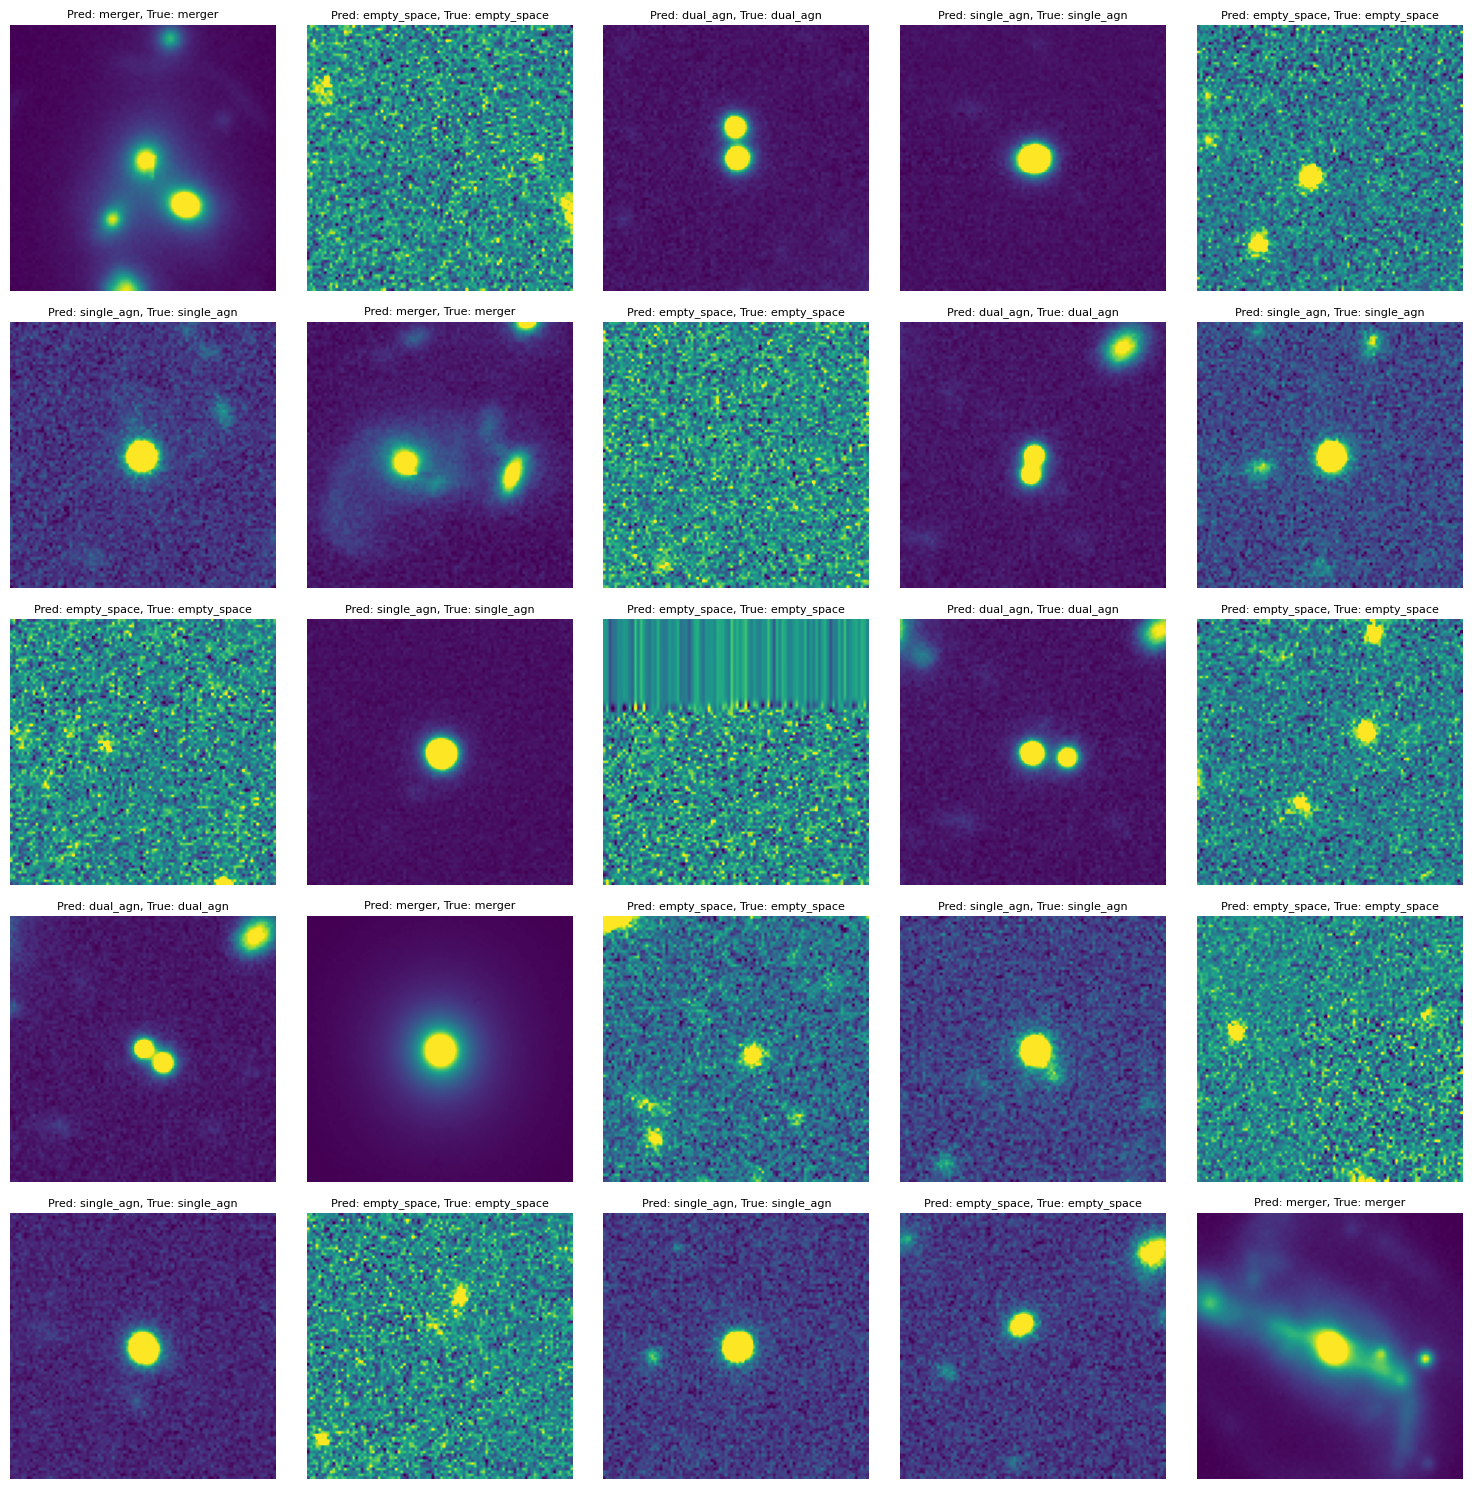

In [81]:
# For all iamges in general
desired_images = fits_images

num_images = min(len(desired_images), 25)
random_offset_selection = np.random.choice(len(desired_images), size=num_images, replace=False)

# Determine the grid size
grid_size = int(np.ceil(np.sqrt(num_images)))

fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))
axes = axes.flatten()

for i in range(num_images):
    idx = random_offset_selection[i]
    img = desired_images[idx]
    img_name = image_files[idx]
    
    ax = axes[i]
    ax.imshow(img, vmin=np.percentile(img, 1), vmax=np.percentile(img, 99), cmap='viridis')
    ax.set_title(f"Pred: {pred_labels[idx]}, True: {true_labels[idx]}", fontsize=8)
    ax.axis('off')

# Turn off any unused axes if num_images < grid_size^2
for j in range(num_images, grid_size * grid_size):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

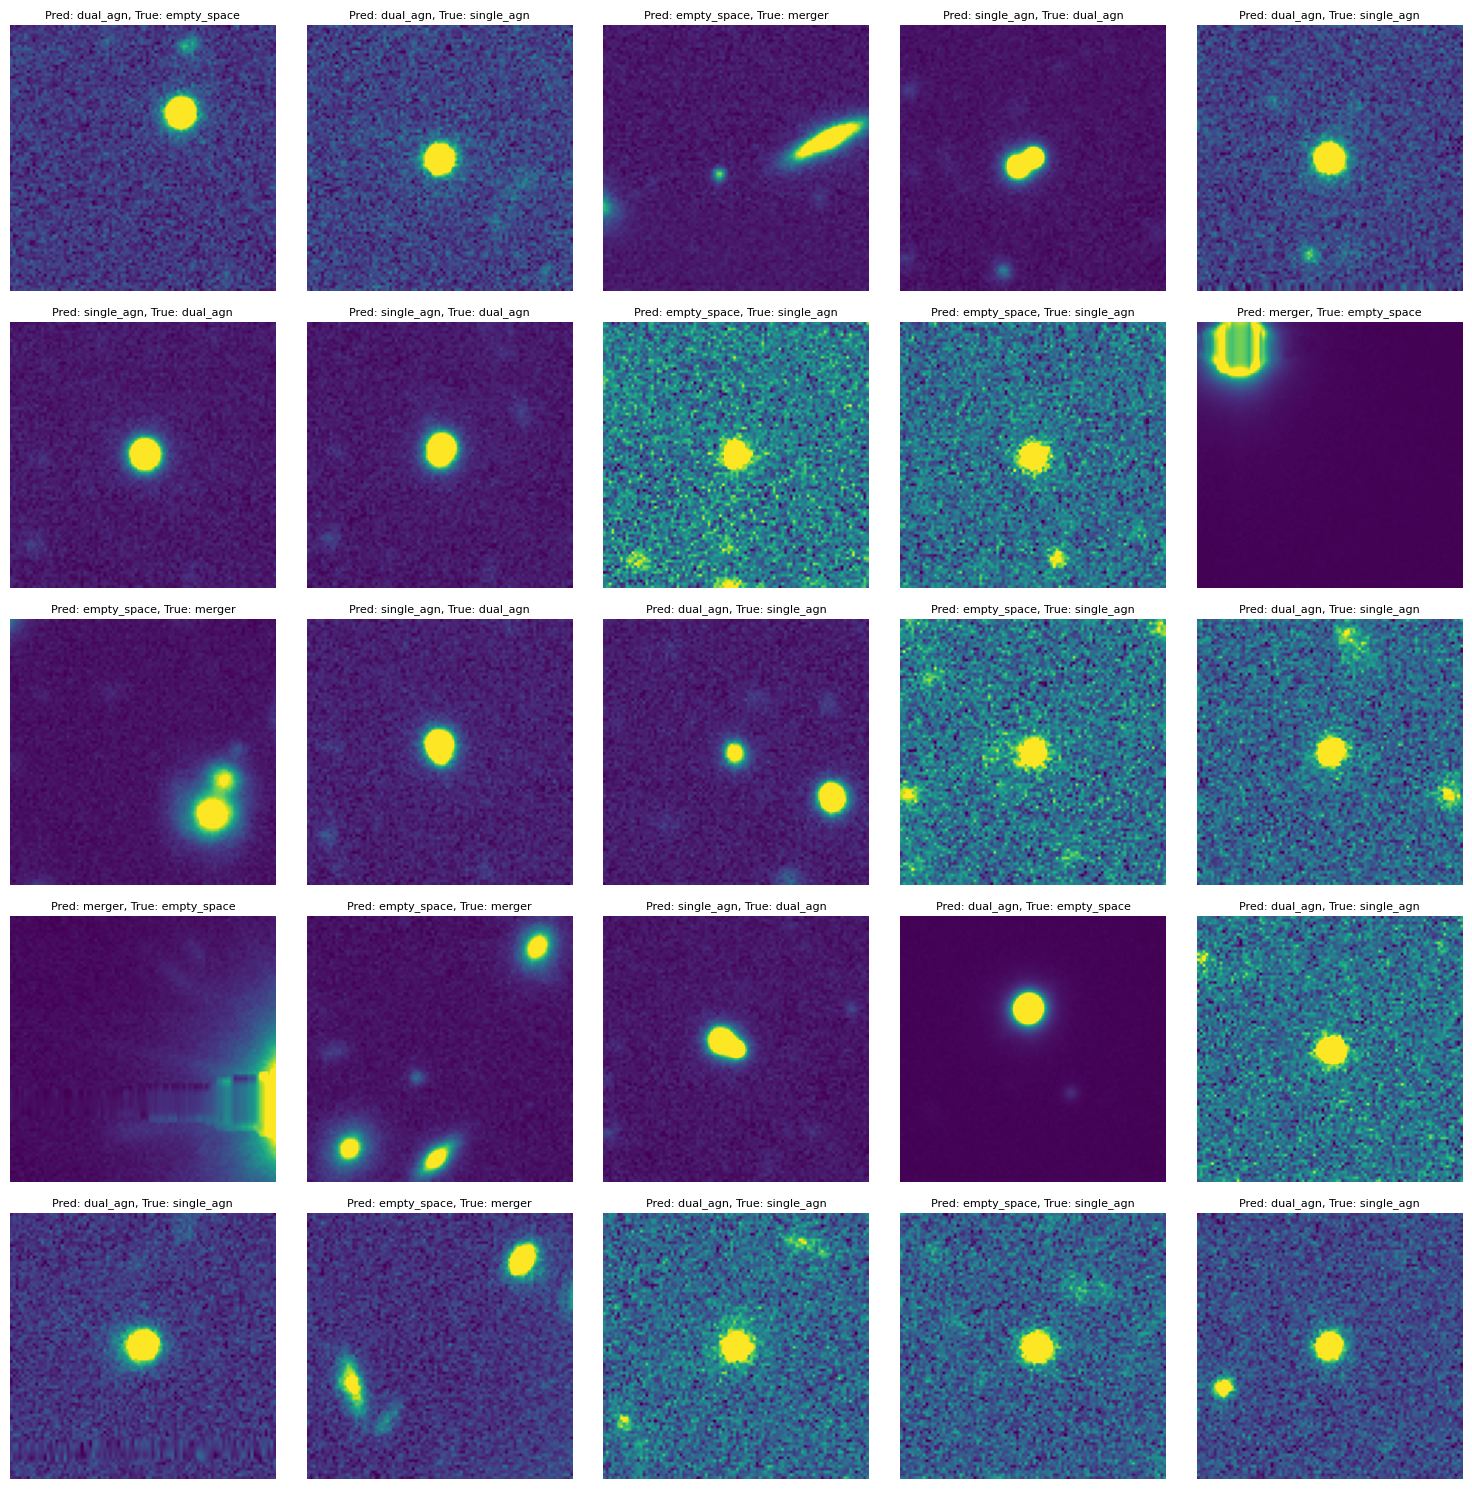

In [80]:
# For mismatched images
desired_images = fits_images

num_images = min(len(desired_images), 25)
random_offset_selection = np.random.choice(len(mismatched_images), size=num_images, replace=False)

# Determine the grid size
grid_size = int(np.ceil(np.sqrt(num_images)))

fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))
axes = axes.flatten()

for i in range(num_images):
    idx = random_offset_selection[i]
    img = desired_images[mismatched_images[idx]]
    img_name = image_files[mismatched_images[idx]]
    
    ax = axes[i]
    ax.imshow(img, vmin=np.percentile(img, 1), vmax=np.percentile(img, 99), cmap='viridis')
    ax.set_title(f"Pred: {pred_labels[mismatched_images[idx]]}, True: {true_labels[mismatched_images[idx]]}", fontsize=8)
    ax.axis('off')

# Turn off any unused axes if num_images < grid_size^2
for j in range(num_images, grid_size * grid_size):
    axes[j].axis('off')

plt.tight_layout()
plt.show()